# Air flow by ventilation

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/cghiaus/dm4bem_book/HEAD?labpath=%2Ftutorials%2FA03Air_flow_ventilation.ipynb)

## Problem
The natural ventilation system of a two-storey building is composed of (Figure 1):
- Orrifices located on the north and south faces located at hight $z_0 = 0.5 \, \mathrm{m}$. Every façade has two orrifices with the pressure exponent $n_o = 0.64$ and the flow coefficient $K_o = 10 \, \mathrm{m^3/(h\,Pa}^{n_o})$.
- An exhaust air chimney on the south side of the roof at hight $z_c = 8.5 \, \mathrm{m}$. This chimney may be considered an orrifice with the pressure exponent $n_c = 0.50$ and the flow coefficient $K_c = 50 \, \mathrm{m^3/(h\,Pa}^{n_c})$.
- The other elements of the building are considered airthight.

![vent_bldg](../figures/A03_nat_vent.svg)
> Figure 1. Natural ventilation with wind and stack effect.

The static pressure at the level of the orrifices is considered $P_o = 0 \, \mathrm{Pa}$.

Let's consider that the outdoor air has the parameters $\theta_o = -5 \, \mathrm{°C}$, $\varphi_o = 100 \, \%$, $\rho_o = 1.315 \, \mathrm{kg/m^3}$ and the indoor air has the parameters $\theta_i = 22 \, \mathrm{°C}$, $\varphi_i = 50 \, \%$, $\rho_i = 1.191 \, \mathrm{kg/m^3}.$

In these conditions, estimate:
- The possible domain of variation for the indoor pressure $p_i$ for the flow configuration shown in Figure 1.
- The value of the indoor pressure $p_i$.
- The mass flow rates:
    - $\dot m_{ni}$: from outdoors to indoors through the nord façade;
    - $\dot m_{ci}$: from outdoors to indoors through the south façade;
    - $\dot m_{ic}$: from indoors to outdoors through the chimney;
    
in two situations:
1. Neglecting the wind effect.
2. Considering that the wind blows from North to South with speed $v = 18 \, \mathrm{km/h}$ and that the pressure coefficients are $C_{p,n} = 0.4$ for the north face, $C_{p,s} = -0.55$ for the south face, and $C_{p,c} = -0.7$ for the chimney. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve

# Data
# Data
g = 9.8                             # m/s², acceleration due to gravity
no, nc = 0.64, 0.50                 # -, pressure exponent: orrifice, chimney
Ko, Kc = 10 / 3600, 50 / 3600       # m³/(s·Paⁿ), flow coeff.: orrifice, chimney
ρi, ρo = 1.191, 1.315               # kg/m³, density: indoor, outdoor
Cpn, Cps, Cpc = 0.4, -0.55, -0.7    # -, presseure coef.: north, south, chimney
z = 8                               # m, hignt

## Summary of theory

### Sources
#### Pressure sources

Pressure sources [(Rock et al. 2017)](https://ia802804.us.archive.org/23/items/ashraehandbook2017hvacfundamentalssi/2017%2C%20ashrae%20fundamental%20handbook%20SI.pdf):
- stack pressure: $P_s = P_0 - \rho g z$;
- wind pressure: $P_w = C_p \frac{1}{2} \rho_o v^2$

where:
- $P_s$ stack pressure, Pa
- $P_0$ stack pressure at reference height, Pa
- $g$ gravitational acceleration, m/s²
- $\rho$ indoor or outdoor air density, kg/m³
- $z$ height above the reference level, m
- $P_w$ wind pressure difference relative to the outdoor pressure in undisturbed flow, Pa
- $C_p$ pressure coefficient, dimensionless
- $\rho_o$ outside air density, kg/m³
- $v$ wind speed, m/s

#### Flow sources
Flow sources inject a controlled volumetric airflow rate into the control volume, as is the case in [balanced mechanical ventilation systems](https://en.m.wikipedia.org/wiki/Ventilation_(architecture)).

### Constitutive equation

Each opening of a building can be modelled by a [constitutive equation](https://en.m.wikipedia.org/wiki/Constitutive_equation) or power law [(Rock et al. 2017)](https://ia802804.us.archive.org/23/items/ashraehandbook2017hvacfundamentalssi/2017%2C%20ashrae%20fundamental%20handbook%20SI.pdf):

$$ \dot V_{i,j} = K_{i,j} \Delta P^n_{i,j} = K_{i,j}(P_i - P_j)^n$$

where:
- $\dot V_{i,j}$ volumetric airflow through opening from control volume $i$ to control volume $j$, m³/s
- $n$ pressure exponent, dimensionless; typical value about 0.65
- $K_{i,j}$ flow coefficient, m³/(s·Paⁿ)

The values of the pressure exponent $n$ and flow coefficient $K_{i,j}$ cann be obtained experimentally by using the [blower door](https://en.wikipedia.org/wiki/Blower_door) test.

### Mass conservation equation

In steady-state, the [mass conservation](https://en.m.wikipedia.org/wiki/Conservation_of_mass) law states that the algebraic sum of mass flow rates entering in a control volume $j$ is zero:

$$\sum_i \dot m_{i,j} = 0$$

Mass air flow rate from control volume $i$ to control volume $j$ is:

$$ \dot m_{i,j} = \rho_i \, \dot V_{i,j}$$

where:
- $\dot m_{i,j}$ mass flow rate of air from control volume $i$ to control volume $j$, kg/s 
- $\rho_i$ air density in control volume $i$, kg/m³
- $\dot V_{i,j}$ volumetric air flow rate from control volume $i$ to control volume $j$, m³/s

**Notes:**
1. The constitutive law relates volumetric airflow to pressure difference.
2. The balance equation is done for mass flow rate.
3. Generally, $\dot m_{i,j} \neq \dot m_{j,i}$, even if $\dot V_{i,j} = \dot V_{j,i}$. This implies that if the mass flow rates obtained by solving the aeraulic circuit are negative, than the direction of the flows need to changed and a new solution to be searched for.

### Domain of variation for the indoor pressure

For the flow directions shown in Figure 1,

$$
\left\{\begin{matrix}
\dot m_{i,c} > 0\\ 
\dot m_{n,i} > 0\\ 
\dot m_{s,i} > 0
\end{matrix}\right.
$$


For

$$\dot m_{i,c} > 0$$

the indoor pressure $p_i$ needs to satisfy the inequality (see Figure 2a):

$$p_i + [P_{si} - (P_{dc} + P_{sc})] > 0$$

or the inequality (see Figure 2b):

$$p_i > P_{dc} + P_{sc} - P_{si}$$

For 

$$
\left\{\begin{matrix}
\dot m_{n,i} > 0\\ 
\dot m_{s,i} > 0
\end{matrix}\right.
$$

the condition

$$p_i \le \min (P_{dn},P_{ds})$$

needs to be satisfied (Figures 1 and 2).

![vent_bldg](../figures/A03_nat_vent_1P.svg)
> Figure 2. The model from Figure 1 with only one pressure source on a branch: a) pressure source before conductance; b) pressure source after conductance.

## Static pressure

- $P_{si} = - \rho_i g z$ indoors
- $P_{so} = - \rho_o g z$ outdoors

In [2]:
# Static pressure, Pa
Psi = -ρi * g * z   # indoors
Pso = -ρo * g * z   # outdoors

## Neglecting the wind effect

### Dynamic pressure

The dynamic pressures are:
- $P_{dn} = C_{pn} \frac{1}{2} \rho_o v^2$ - north face
- $P_{ds} = C_{ps} \frac{1}{2} \rho_o v^2$ - south face
- $P_{dc} = C_{pc} \frac{1}{2} \rho_o v^2$ - chimney

In [3]:
v = 0       # m/s, wind speed
# dynamic pressures, Pa
Pdn = Cpn * 0.5 * ρo * v**2     # north face
Pds = Cps * 0.5 * ρo * v**2     # south face
Pdc = Cpc * 0.5 * ρo * v**2     # chimney

### Variation domain of indoor pressure
The domain of variation of $p_i$ in order to have the flows shown in Figure 1 is

$$P_{si} - (P_{dc} + P{sc}) \le p_i \le \min (P_{dn},P_{ds})$$

In [4]:
pi_min, pi_max = -(Psi - Pdc - Pso), min(Pdn, Pds)
print(f"Pressure domain: {pi_min:.2f} Pa < pi < {pi_max:.2f} Pa")

Pressure domain: -9.72 Pa < pi < 0.00 Pa


### Graphical solution of nonlinear equation for indoor pressure

The mass flow balance equation for pressure node $p_i$ is:

$$ \dot m_{ni} + \dot m_{si} - \dot m_{ic} = 0$$

where:
- $ \dot m_{ni} = 2 \rho_o K_o (P_{dn} - P_{i})^{n_o}$ - mass flow through the two orifices on north façade;
- $ \dot m_{si} = 2 \rho_o K_o (P_{ds} - P_{i})^{n_o}$ - mass flow through the two orifices on south façade;
- $ \dot m_{ic} = \rho_i K_c (p_i + P_{si} - P_{dc} - P_{so})^{n_c}$ - mass flow from indoor air through the chimney.

The mass balance is satisfied for the indoor pressure $p_i$ which solves the equation:

$$f(p_i) = 0$$

where:

$$f(p_i) = 2 \rho_o K_o (P_{dn} - P_{i})^{n_o} + 2 \rho_o K_o (P_{ds} - P_{i})^{n_o} - \rho_i K_c (p_i + P_{si} - P_{dc} - P_{so})^{n_c}$$

In [5]:
def f(pi):
    """
    Error in mass balance equation as a function of indoor pressure.
    Used to find indoor pressure pi which makes the mass balance zero.
    The north and south flows are enteriing.

    Parameters
    ----------
    pi : float
        Indoor pressure, Pa.

    Returns
    -------
    y : float
        Mass flow rate unbalanced in the mass balance equation
    """
    y = 2 * ρo * Ko * (Pdn - pi)**no \
        + 2 * ρo * Ko * (Pds - pi)**no \
        - ρi * Kc * (pi + Psi - Pdc - Pso)**nc
    return y

The solution of this non-linear equation can be found graphically.

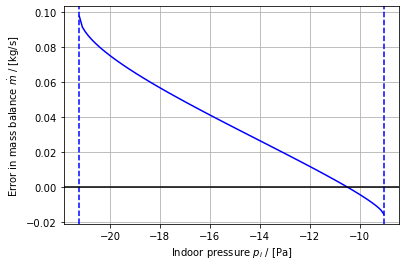

In [14]:
# plot error in mass balance
pi = np.linspace(pi_min, pi_max, 100)

fig, ax = plt.subplots()

ax.plot(pi, f(pi), 'b')
ax.axvline(x=pi_min, color='b', **{'linestyle': 'dashed'})
ax.axvline(x=pi_max, color='b', **{'linestyle': 'dashed'})
ax.axhline(color='k')

ax.set_ylabel(r'Error in mass balance $\dot{m}$ / [kg/s]')
ax.set_xlabel(r'Indoor pressure $p_i$ / [Pa]')
ax.grid()

> Figure 3. [Residual](https://en.wikipedia.org/wiki/Residual_(numerical_analysis)) of mass balance equation in the dolain of pressure variation (without wind effect).

### Numerical solution

Alternativelly, the solution to the equation

$$f(p_i) = 0$$

can be found numerically.

In [7]:
# numerical solution
root = float(fsolve(f, np.mean([pi_min, pi_max])))
print(f"pi = {root:.2f} Pa")

pi = -4.45 Pa


### Check the mass balance

By knowing the indoor pressure $p_i$, the mass flows  $\dot m_{ni}$, $\dot m_{si}$ and $\dot m_{ic}$  can be found and the mass balance

$$ \dot m_{ni} + \dot m_{si} - \dot m_{ic} = 0$$

checked.

In [8]:
# verification of mass balance, kg/s
mn = ρo * Ko * (Pdn - root)**no
ms = ρo * Ko * (Pds - root)**no
mc = ρi * Kc * (root + Psi - Pdc - Pso)**nc
print("Verify mass balance:")
print(f"mass flow: north: {2 * mn:.3f} kg/s, south: {2 * ms:.3f} kg/s")
print(f"mass flow chimney: {mc:.3f} kg/s")
print(f"error in mass flow balance: {2 * mn + 2 * ms - mc:.3f} kg/s\n")

Verify mass balance:
mass flow: north: 0.019 kg/s, south: 0.019 kg/s
mass flow chimney: 0.038 kg/s
error in mass flow balance: 0.000 kg/s



## Considering the wind effect

### Dynamic pressure

The dynamic pressures are:
- $P_{dn} = C_pn \frac{1}{2} \rho_o v^2$ - north face
- $P_{ds} = C_ps \frac{1}{2} \rho_o v^2$ - south face
- $P_{dc} = C_pc \frac{1}{2} \rho_o v^2$ - chimney

In [9]:
v = 18 * 1000 / 3600            # m/s, wind speed

# dynamic pressures, Pa
Pdn = Cpn * 0.5 * ρo * v**2     # north face
Pds = Cps * 0.5 * ρo * v**2     # south face
Pdc = Cpc * 0.5 * ρo * v**2     # chimney

### Domain of variation of indoor pressure
The domain of variation of $p_i$ in order to have the flows shown in Figure 1 is:

$$P_{si} - (P_{dc} + P{sc}) \le p_i \le \min (P_{dn},P_{ds})$$

In [10]:
pi_min, pi_max = -(Psi - Pdc - Pso), min(Pdn, Pds)
print(f"Pressure domain with wind: {pi_min:.2f} Pa < pi < {pi_max:.2f} Pa")

Pressure domain with wind: -21.23 Pa < pi < -9.04 Pa


### Graphical solution of nolinear equation for indoor pressure

The solution of this non-linear equation can be found graphically (Figure 4).

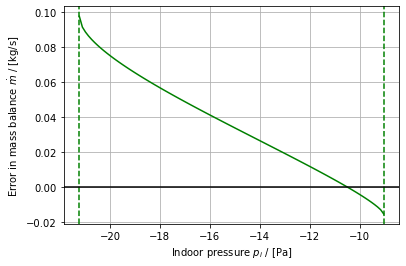

In [15]:
# plot error in mass balance
pi = np.linspace(pi_min, pi_max, 100)

fig, ax = plt.subplots()

ax.plot(pi, f(pi), 'g')
ax.axvline(x=pi_min, color='g', **{'linestyle': 'dashed'})
ax.axvline(x=pi_max, color='g', **{'linestyle': 'dashed'})
ax.axhline(color='k')

ax.set_ylabel(r'Error in mass balance $\dot{m}$ / [kg/s]')
ax.set_xlabel(r'Indoor pressure $p_i$ / [Pa]')
ax.grid()

> Figure 4. [Residual](https://en.wikipedia.org/wiki/Residual_(numerical_analysis)) of mass balance equation in the domain of pressure variation (with wind effect).

### Numerical solution

Alternativelly, the solution to the equation

$$f(p_i) = 0$$

can be found numerically.

In [12]:
# numerical solution
root = float(fsolve(f, np.mean([pi_min, pi_max])))
print(f"pi = {root:.2f} Pa")

pi = -10.50 Pa


### Check the mass balance

By knowing the indoor pressure $p_i$, the mass flows  $\dot m_{ni}$, $\dot m_{si}$ and $\dot m_{ic}$  can be found and the mass balance

$$ \dot m_{ni} + \dot m_{si} - \dot m_{ic} = 0$$

checked.

In [13]:
mn = ρo * Ko * (Pdn - root)**no
ms = ρo * Ko * (Pds - root)**no
mc = ρi * Kc * (root + Psi - Pdc - Pso)**nc
print("Verify mass balance:")
print(f"mass flow: north: {2 * mn:.3f} kg/s, south: {2 * ms:.3f} kg/s")
print(f"mass flow chimney: {mc:.3f} kg/s")
print(f"error in mass flow balance: {2 * mn + 2 * ms - mc:.3f} kg/s\n")

Verify mass balance:
mass flow: north: 0.045 kg/s, south: 0.009 kg/s
mass flow chimney: 0.054 kg/s
error in mass flow balance: 0.000 kg/s



## References
[B. Rock, S.J. Emmerich, S. Taylor (2017)](https://ia802804.us.archive.org/23/items/ashraehandbook2017hvacfundamentalssi/2017%2C%20ashrae%20fundamental%20handbook%20SI.pdf) *F16 Ventilation and Infiltration* in ASHRAE Fundamentals Handbook, ISBN 10: 1939200598  ISBN 13: 978-1939200594